#### Testeo Modelos 
En este sección vamos a realizar testeos de los diferentes modelos que se guardaron.

Recorda que hicimos entrenamiento por separado. Por un lado tenemos un entrenamiento basado solo en 
latitudes y longitudes, es decir un modelo de predicción de latitudes y longitudes, y por otro lado se tiene un modelo dedicado solo a la prediccion de las alturas. 

In [87]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [88]:
x_test = pd.read_csv("./Train_Test/x_test.csv")
y_test = pd.read_csv("./Train_Test/y_test.csv")

In [89]:
autoencoder_Lat_Lon = tf.keras.models.load_model('modelos_entrenamiento/entrenamiento_lat_lon2.keras')
autoencoder_Height = tf.keras.models.load_model('modelos_entrenamiento/entrenamiento_alturas2.keras')

In [90]:
# Predecimos una muestra en particular de mi df
idx = 10 
#=====Latitudes Longitudes=====
y_pred_lat_lon = autoencoder_Lat_Lon.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_true =y_test.iloc[idx]
# Separamos Latitudes Longitudes
y_true_latitudes = y_true[0:100]
y_true_longitudes = y_true[100:200]
y_pred_latitudes = y_pred_lat_lon[0,0:100]
y_pred_longitudes = y_pred_lat_lon[0,100:200]

#====== Alturas =======
y_pred_heights = autoencoder_Height.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_pred_heights = y_pred_heights[0,0:100]
y_true_heights = y_true[200:300]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


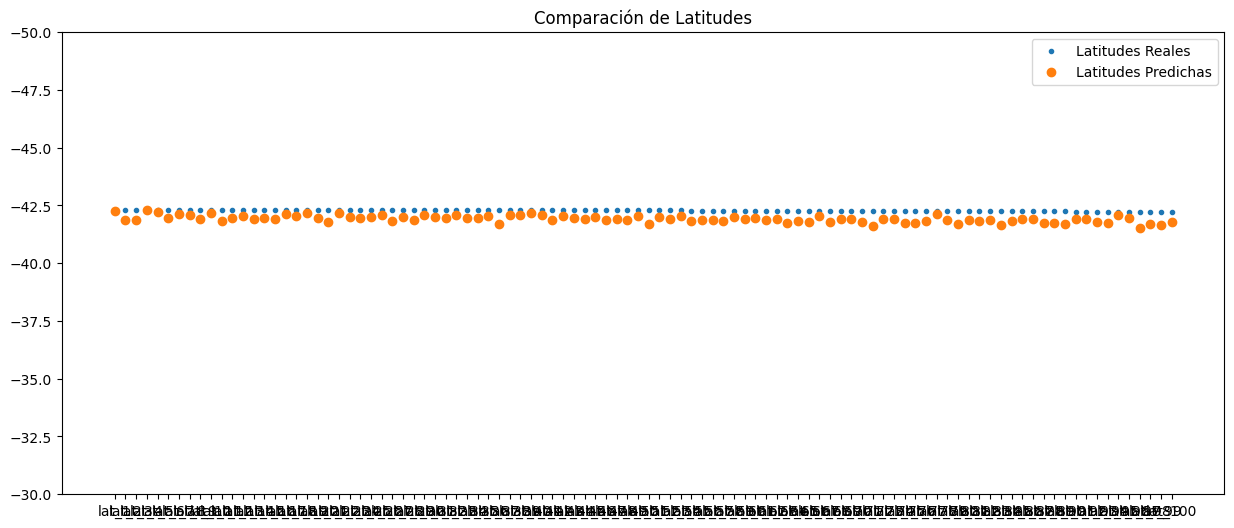

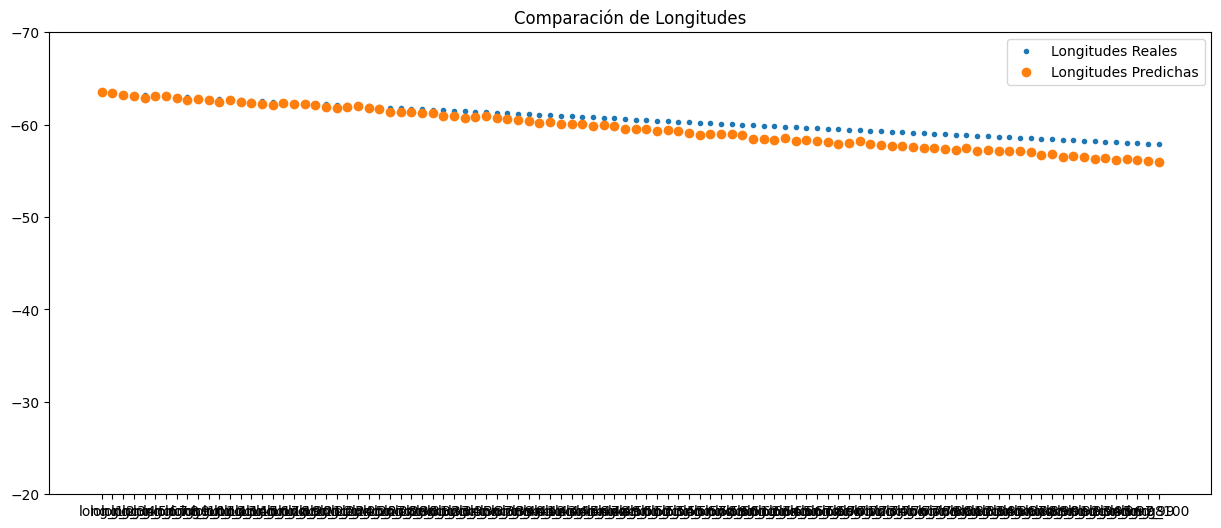

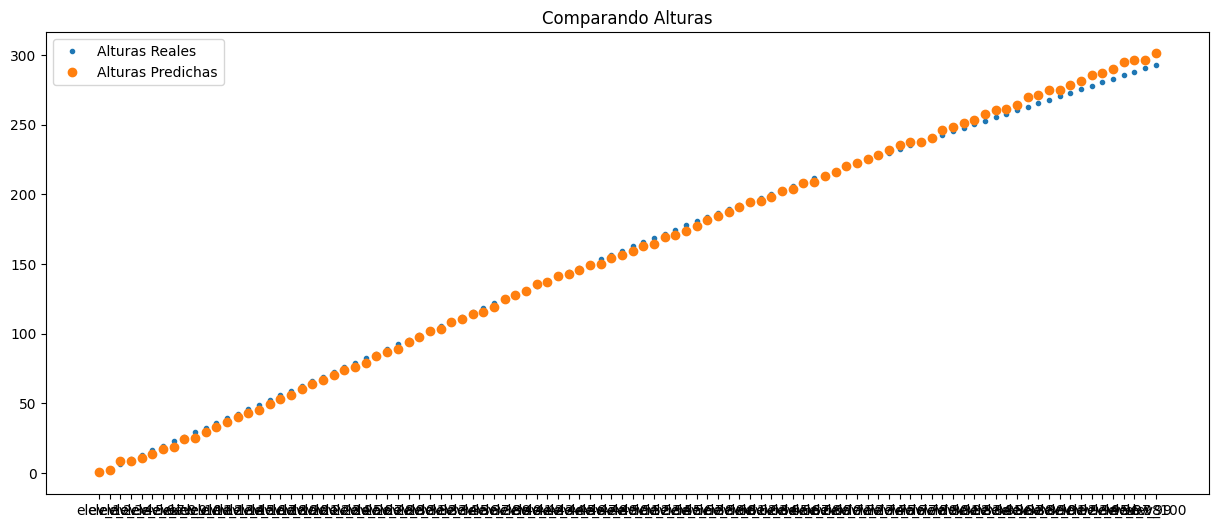

In [91]:
# Grafica Latitudes 
plt.figure(figsize = (15,6))
plt.plot(y_true_latitudes, label = 'Latitudes Reales', linestyle = 'None', marker = '.')
plt.plot(y_pred_latitudes, label = 'Latitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-30,-50)
plt.title('Comparación de Latitudes')
plt.legend()
plt.show()

# Graf. Longitudes
plt.figure(figsize=(15,6))
plt.plot(y_true_longitudes,label= 'Longitudes Reales', linestyle = 'None',marker= '.')
plt.plot(y_pred_longitudes,label= 'Longitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-20,-70)
plt.title("Comparación de Longitudes")
plt.legend()
plt.show()

# Graf. Alturas
plt.figure(figsize=(15,6))
plt.plot(y_true_heights, label = "Alturas Reales",linestyle= 'None', marker = '.')
plt.plot(y_pred_heights, label = "Alturas Predichas", linestyle = 'None', marker = 'o')
plt.title("Comparando Alturas")
plt.legend()
plt.show()

## Errores 
1. Error de manera individual:
  * Puedo calcular $d_{2D}$ usando **geopy.distance.geodesic**.
  * Luego calcular la diferencia de alturas $\Delta z$
  * Finalmente usar un $d_{3D} = \sqrt{(d_{2D})^2 + (\Delta z)^2}$ y así obtendría mi distancia en 3D.
2. ECM
  * Para obtener el Error Cuadrático Medio puedo, sumar los valores y dividir por la cantidad de puntos (100 puntos)
3. RECM(RMSE)
  * Por último se podría tomar la raiz del ECM para expresar el error promedio en metros.

In [92]:
#NOTA:
#   Las variables lat_true_degrees,lon_true_degrees proviene de objetos pandas.Series por lo que se tiene
#   que convertir a un array Numpy.
#   Por otro lado lat_pred_degrees,lon_pred_degrees provienen de objetos array Numpy. Por lo que 
#   no se tiene que transformar.
def Rango_Ground(lat_true_degrees,lon_true_degrees,lat_pred_degrees,lon_pred_degrees): #Determinación de Rango Terrestre
    lat_true_degrees = lat_true_degrees.to_numpy()
    lon_true_degrees = lon_true_degrees.to_numpy()
    #lat_pred_degrees = lat_pred_degrees.to_numpy()
    #lon_pred_degrees = lon_pred_degrees.to_numpy()

    lat_true = np.radians(lat_true_degrees)
    lon_true = np.radians(lon_true_degrees)
    lat_pred = np.radians(lat_pred_degrees)
    lon_pred = np.radians(lon_pred_degrees)    
    
    Re = 6371e3 # Radio de la tierra (m)
    aux = (np.sin((lat_pred-lat_true)/2))**2 + np.cos(lat_true)*np.cos(lat_pred)*(np.sin((lon_pred-lon_true)/2))**2 
    Range = 2 * Re * np.arcsin(np.sqrt(aux))/1000 #Km
    return Range

In [93]:
Rango = Rango_Ground(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes)

In [94]:
# Calculamos el error 
error = np.sum(Rango**2)/len(Rango)

print("Raiz del ECM:",np.sqrt(error))


Raiz del ECM: 100.992827922545


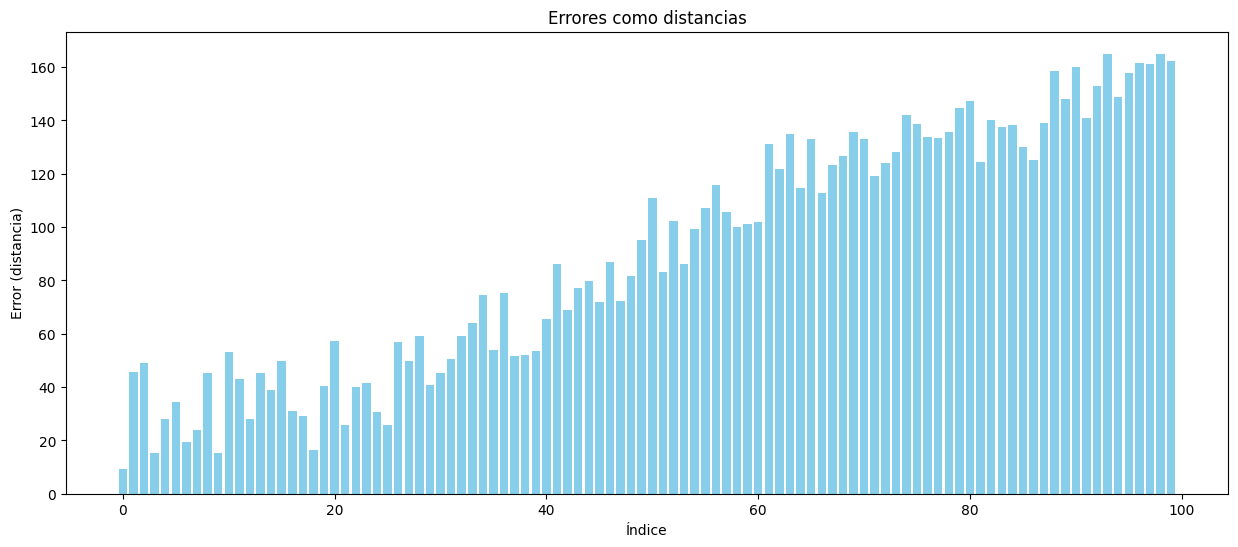

In [102]:
plt.figure(figsize=(15,6))
plt.bar(range(len(Rango)), Rango, color='skyblue')
plt.xlabel('Índice')
plt.ylabel('Error (distancia)')
plt.title('Errores como distancias')
plt.show()

In [ ]:
# Diagrama de Caja

# plt.figure(figsize=(15,6))
# plt.boxplot(Rango/1000, vert=False)
# plt.xlabel('Error (distancia)')
# plt.title('Distribución de errores')
# plt.show()

In [ ]:
#Ahora vamos a corroborar usando una biblioteca
from geopy.distance import geodesic

def Distance_and_Error(lat_true,lon_true,lat_pred,lon_pred):
  lat_true = lat_true.to_numpy()
  lon_true = lon_true.to_numpy()

  errors = np.array([])

  for lat_t,lon_t,lat_p,lon_p in zip(lat_true,lon_true,lat_pred,lon_pred):
    real_coord = (lat_t,lon_t)
    predict_coord = (lat_p,lon_p)

    distance = geodesic(real_coord,predict_coord).kilometers
    errors = np.append(errors,distance)
  return errors


distance = Distance_and_Error(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes) #Km
print("distancia 2D:",distance[99])
sq_distance = distance**2
errors_1 = np.sum(sq_distance)/len(sq_distance) #ECM
sqrt_error_1 = np.sqrt(errors_1)
print("Raiz del error ECM:",sqrt_error_1)


distancia 2D: 162.52372712087538
Raiz del error ECM: 101.19341428953206


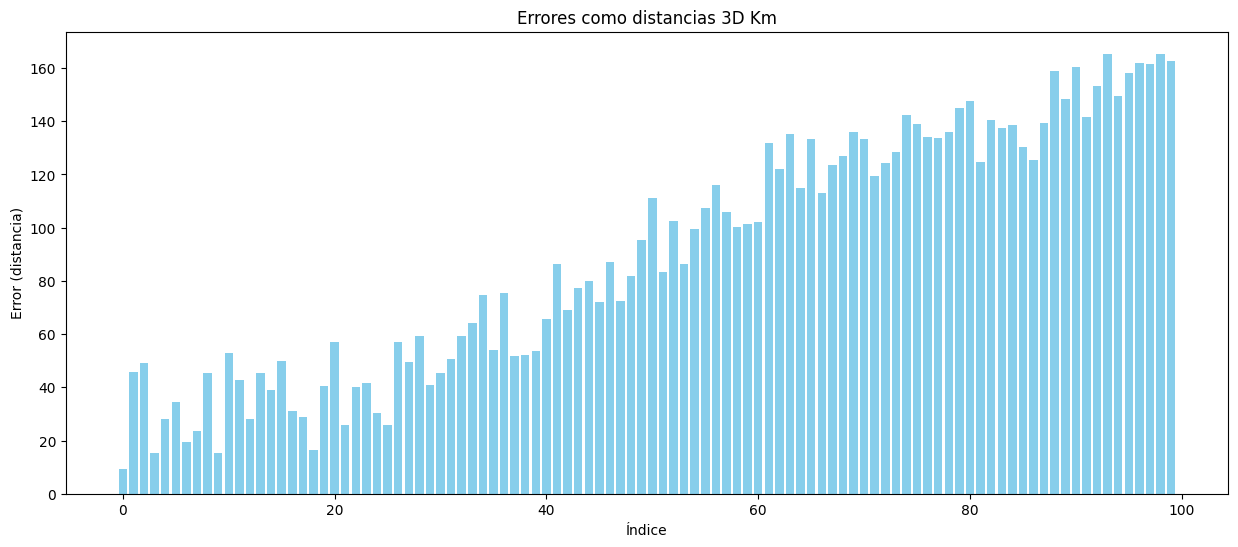

In [98]:
plt.figure(figsize=(15,6))
plt.bar(range(len(distance)), distance, color='skyblue')
plt.xlabel('Índice')
plt.ylabel('Error (distancia)')
plt.title('Errores como distancias 3D Km')
plt.show()

In [99]:
# Ahora calculamos la distancia 3D
# Las alturas true and pred estan en km RECORDAR. Ver que el input distance2D tiene que estar en la misma unidad.
# Tener en cuenta que true_heights es tipo Serie por lo que transformamos a array numpy.
def distance_3D(distance2D, true_heights, pred_heights):
  true_heights= true_heights.to_numpy() 
  dif_heights = true_heights - pred_heights

  distance_3d = np.sqrt(distance2D**2 + dif_heights**2)
  return distance_3d 


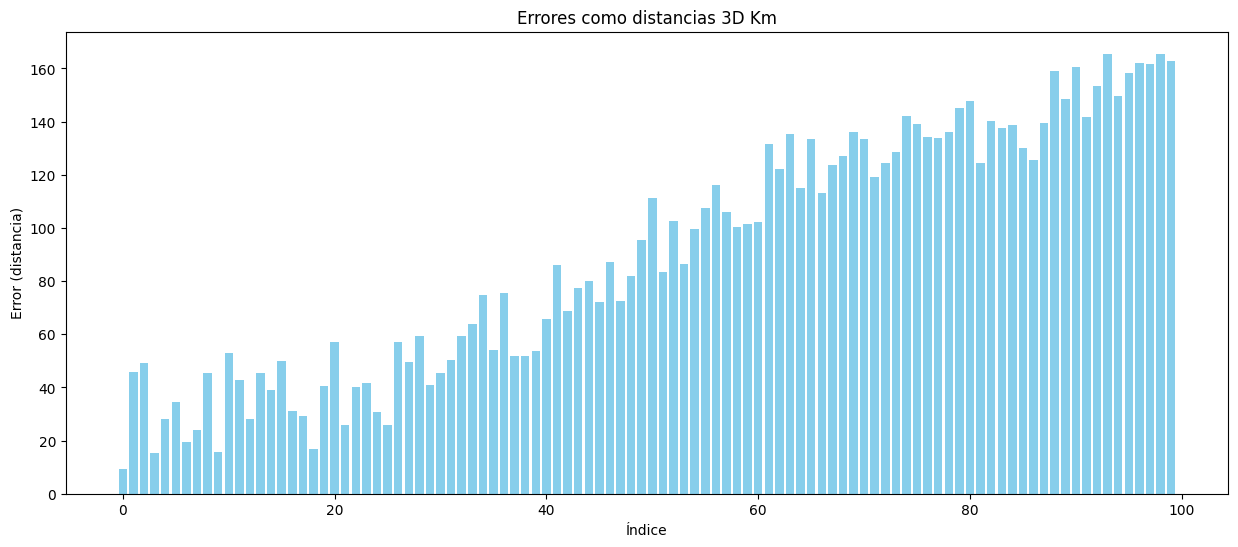

In [100]:
distance_3d = distance_3D(distance,y_true_heights,y_pred_heights)   

plt.figure(figsize=(15,6))
plt.bar(range(len(distance_3d)), distance_3d, color='skyblue')
plt.xlabel('Índice')
plt.ylabel('Error (distancia)')
plt.title('Errores como distancias 3D Km')
plt.show()

In [101]:
ECM_3d = np.sum(distance_3d**2)/len(distance_3d)
RECM_3d = np.sqrt(ECM_3d)
RECM_3d

101.24995113799994